In [96]:
import matplotlib
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ray
import json
import os
import mlflow
import os
import gym
import ray
import tqdm
import json
import pickle
import argparse
from os import path
from dynaconf import Dynaconf
from ray.rllib.algorithms.dqn import DQN
from replay_buffer.ber import BlockReplayBuffer
from ray.rllib.utils.replay_buffers import ReplayBuffer
from ray.rllib.env.wrappers.atari_wrappers import wrap_deepmind
from ray.tune.logger import UnifiedLogger
from utils import convert_np_arrays, check_path

In [171]:
data_path = "./ex_all.csv"

/tmp/ipykernel_26864/918899114.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["rolling_mean"] = data["episode_reward_mean"].rolling(window=reduced_window_size).mean()
/tmp/ipykernel_26864/918899114.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data["time(h)"] = _data["time_total_s"] / 3600
/tmp/ipykernel_26864/918899114.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

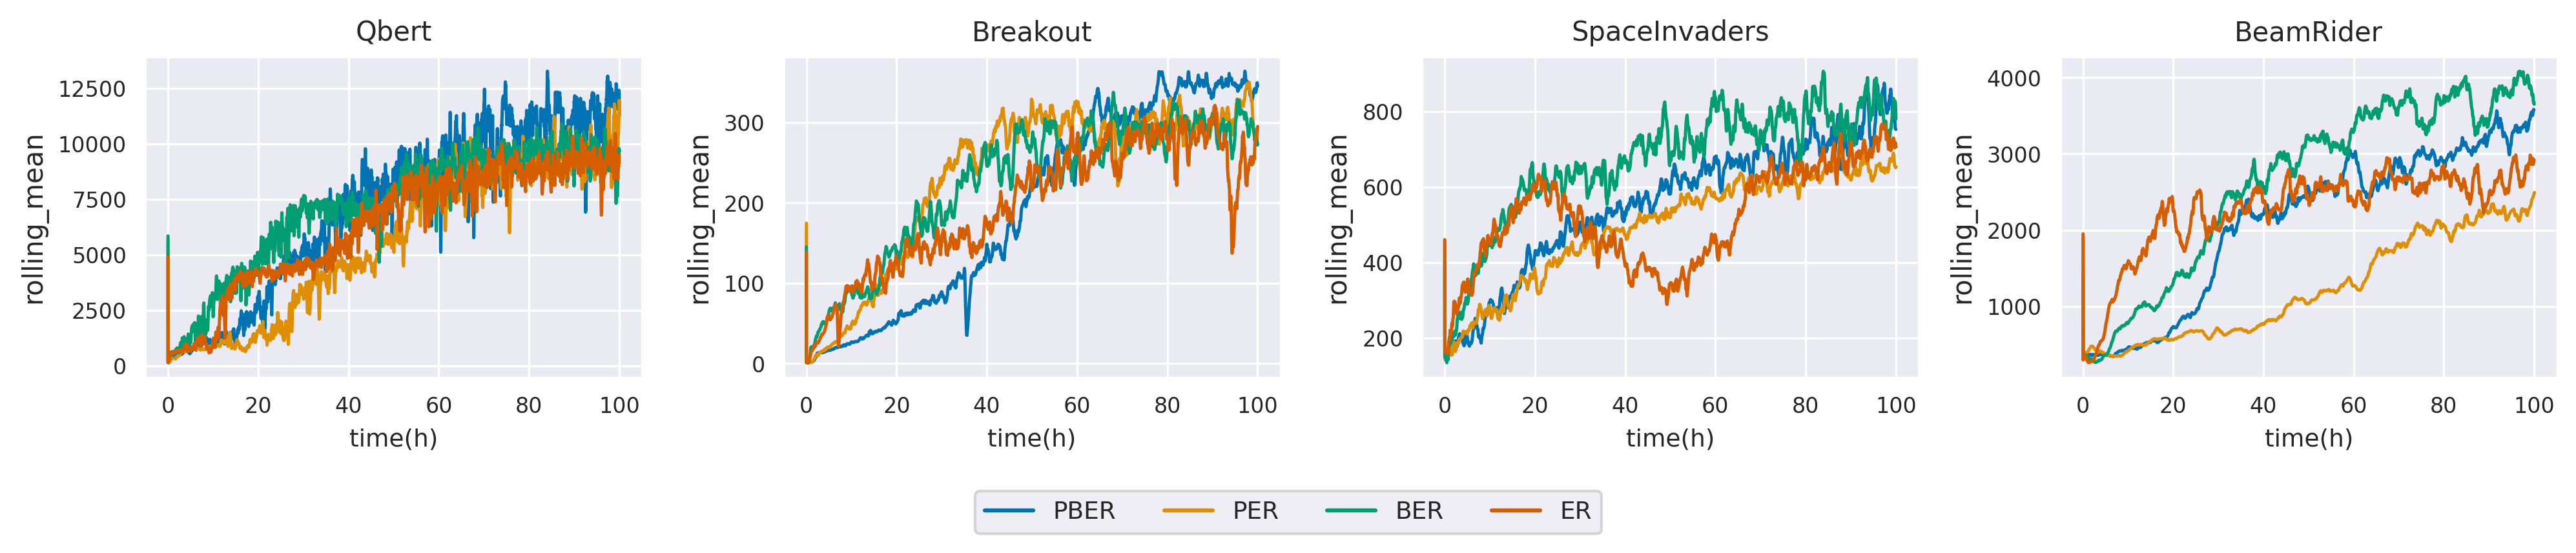

In [172]:
data_df = pd.read_csv(data_path)

# Filter the environments
data_df = data_df[data_df['env'].isin(['BeamRider', 'Breakout', 'Qbert', 'SpaceInvaders'])]
data_df["buffer_type"] = data_df["buffer"]
sampler = {env: data_df[data_df['env'] == env] for env in data_df['env'].unique()}

# Plotting parameters
reduced_window_size = 2
remove_initial_hour = 12

# Adjusting the figure size for a figure* in a double-column format
fig, axes = plt.subplots(1, 4, figsize=(13.4, 2.5), dpi=300)
axes = axes.reshape(-1)
lines_labels = []
labels = {}

# Generating the plots
for ax_n, (env, data) in enumerate(sampler.copy().items()):
    # Calculate rolling mean and filter initial data
    data["rolling_mean"] = data["episode_reward_mean"].rolling(window=reduced_window_size).mean()
    data = data.iloc[remove_initial_hour:]
    
    # Prepare data for plotting
    _data = data[["time_total_s", "rolling_mean", "buffer_type"]]
    _data["time(h)"] = _data["time_total_s"] / 3600
    
    # Plot the data
    palette_env = sns.color_palette("colorblind", data["buffer_type"].nunique())
    ax = sns.lineplot(x="time(h)", y="rolling_mean", hue="buffer_type", data=_data, ax=axes[ax_n], palette=palette_env, linewidth=1.2)
    
    # Adjust axis and titles
    ax.set_title(env, fontsize=10)
    ax.set_xlabel("time(h)", fontsize=9)
    ax.xaxis.set_tick_params(labelsize=8)
    ax.yaxis.set_tick_params(labelsize=8)
    if ax_n != 0:
        ax.get_legend().remove()
    else:
        lines_labels.extend(ax.get_legend_handles_labels() for ax in fig.axes)
        ax.get_legend().remove()

# Adjusting the legend's location
labels, lines = zip(*{i[1]: i[0] for j in lines_labels for i in zip(*j)}.items())
fig.legend(lines, labels, loc="upper center", bbox_to_anchor=(0.5, -0.01), ncol=4, fontsize=9)

# Adjusting the layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

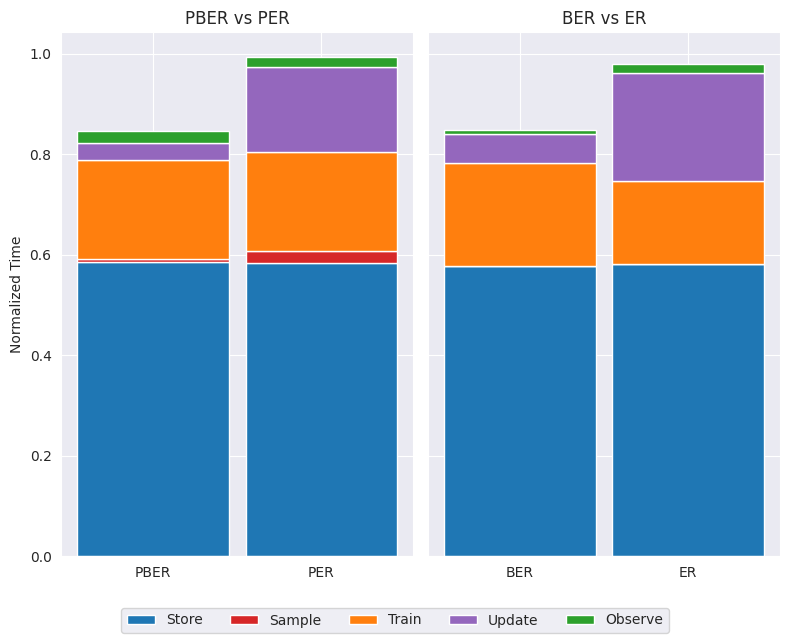

In [173]:
# Load the data

colors = {
    "observe": "#1f77b4",
    "train": "#ff7f0e",
    "store": "#2ca02c",
    "update": "#d62728",
    "sample": "#9467bd"
}

data_df = pd.read_csv(data_path)
filtered_data_df = data_df.copy()
filtered_data_df = filtered_data_df[filtered_data_df["num_env_steps_sampled"] <= 400000]
filtered_data_df["observe"] = filtered_data_df["all"] - filtered_data_df[["store", "sample", "train", "update"]].sum(axis=1)
# First, ensure that all the columns we're working with are of the correct data type.
min_max_sampled_per_pber = filtered_data_df[filtered_data_df['buffer'].isin(['PER', 'PBER'])].groupby(['env', 'buffer'])['num_env_steps_sampled'].max().unstack().min(axis=1)
min_max_sampled_ber_er = filtered_data_df[filtered_data_df['buffer'].isin(['BER', 'ER'])].groupby(['env', 'buffer'])['num_env_steps_sampled'].max().unstack().min(axis=1)

filtered_data_df = filtered_data_df.merge(min_max_sampled_per_pber.reset_index(), on='env', how='left')
filtered_data_df.rename(columns={0: 'num_env_steps_sampled_min_max_for_per_pber'}, inplace=True)

filtered_data_df = filtered_data_df.merge(min_max_sampled_ber_er.reset_index(), on='env', how='left')
filtered_data_df.rename(columns={0: 'num_env_steps_sampled_min_max_for_ber_er'}, inplace=True)

filtered_data_per_pber = filtered_data_df[(filtered_data_df['num_env_steps_sampled'] <= filtered_data_df['num_env_steps_sampled_min_max_for_per_pber']) & filtered_data_df['buffer'].isin(['PBER', 'PER'])]
filtered_data_ber_er = filtered_data_df[(filtered_data_df['num_env_steps_sampled'] <= filtered_data_df['num_env_steps_sampled_min_max_for_ber_er']) & filtered_data_df['buffer'].isin(['BER', 'ER'])]

# Using the provided logic to create the merged_time dataframe
merged_time = []
for i, x in filtered_data_per_pber.groupby(['env', 'num_env_steps_sampled']):
    merged_time.append([i[0], i[1], x["time_total_s"].max()])
merged_time = pd.DataFrame(merged_time, columns=["env", "num_env_steps_sampled", "max_time"])

# Merging the merged_time dataframe with the filtered_data_per_pber and filtered_data_ber_er to get normalization_value
filtered_data_per_pber = filtered_data_per_pber.merge(merged_time, on=["env", "num_env_steps_sampled"], how="left")

# Using the provided logic to create the merged_time dataframe
merged_time = []
for i, x in filtered_data_ber_er.groupby(['env', 'num_env_steps_sampled']):
    merged_time.append([i[0], i[1], x["time_total_s"].max()])
merged_time = pd.DataFrame(merged_time, columns=["env", "num_env_steps_sampled", "max_time"])
filtered_data_ber_er = filtered_data_ber_er.merge(merged_time, on=["env", "num_env_steps_sampled"], how="left")

filtered_data_per_pber.rename(columns={"max_time": "normalization_value"}, inplace=True)
filtered_data_ber_er.rename(columns={"max_time": "normalization_value"}, inplace=True)

# Normalize all columns including 'observe'
columns_to_normalize = ["store", "sample", "train", "update", "observe"]

for col in columns_to_normalize:
    filtered_data_ber_er[col + "_norm"] = filtered_data_ber_er[col] / filtered_data_ber_er["normalization_value"]
    filtered_data_per_pber[col + "_norm"] = filtered_data_per_pber[col] / filtered_data_per_pber["normalization_value"]

fig, axes = plt.subplots(1, 2, figsize=(8,6), sharey=True, dpi=100)

# Adjusting the bar width and position for reduced gap
adjusted_bar_width = 0.9
index_adjusted = np.arange(len(filtered_data_per_pber["buffer"].unique()))

# For PER and PBER
bottom_values_per = np.zeros(len(filtered_data_per_pber["buffer"].unique()))
legend_handles = []  # To collect legend handles
for col in reversed(columns_to_normalize):
    bar_values = filtered_data_per_pber.groupby("buffer")[col + "_norm"].mean()
    bars = axes[0].bar(index_adjusted, bar_values, adjusted_bar_width, color=colors[col], bottom=bottom_values_per, label=col.capitalize())
    bottom_values_per += bar_values.values
    legend_handles.append(bars[0])

# Setting the x-axis labels for PBER and PER
axes[0].set_title('PBER vs PER')
axes[0].set_xticks(index_adjusted)
axes[0].set_xticklabels(bar_values.index)
axes[0].set_ylabel('Normalized Time')

# For BER and ER
bottom_values_er = np.zeros(len(filtered_data_ber_er["buffer"].unique()))
for col in reversed(columns_to_normalize):
    bar_values = filtered_data_ber_er.groupby("buffer")[col + "_norm"].mean()
    axes[1].bar(index_adjusted, bar_values, adjusted_bar_width, color=colors[col], bottom=bottom_values_er)
    bottom_values_er += bar_values.values

# Setting the x-axis labels for BER and ER
axes[1].set_title('BER vs ER')
axes[1].set_xticks(index_adjusted)
axes[1].set_xticklabels(bar_values.index)

# Placing the legend below the plots
fig.legend(legend_handles, [col.capitalize() for col in columns_to_normalize], loc="upper center", bbox_to_anchor=(0.5, -0.01), ncol=len(columns_to_normalize))

plt.tight_layout()
plt.show()

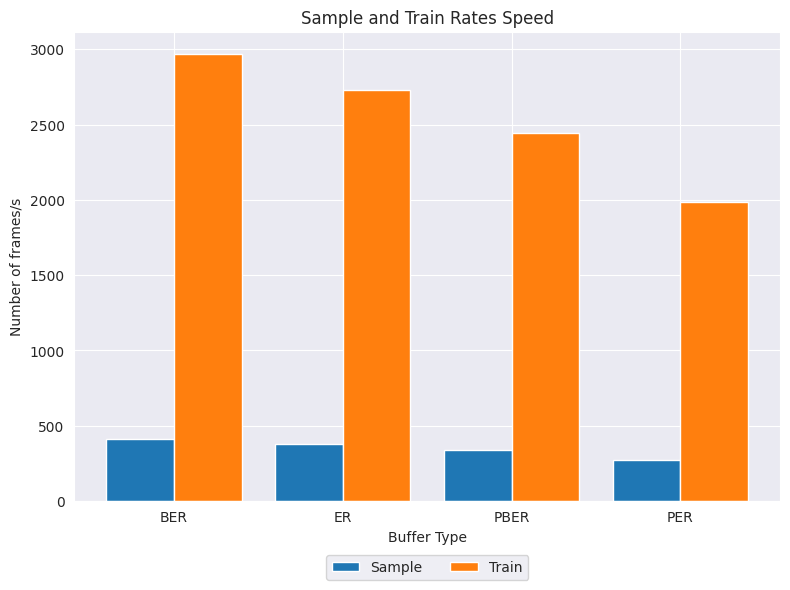

In [174]:
data_df = pd.read_csv(data_path)
data_df = data_df.copy()
data_df = data_df[data_df["num_env_steps_sampled"] <= 400000]

# Add observe column
data_df["num_env_steps_sampled"] = data_df["num_env_steps_sampled"] * 4
data_df["num_env_steps_trained"] = data_df["num_env_steps_trained"] * 4

# Filter only numeric columns for mean calculation
numeric_columns = data_df.select_dtypes(include=[np.number]).columns.tolist()
mean_values_filtered = data_df.groupby(['env', 'buffer'])[numeric_columns].mean().reset_index()

# Calculate the sample and train rates
mean_values_filtered["sample_rate"] = mean_values_filtered["num_env_steps_sampled"] / mean_values_filtered["time_total_s"]
mean_values_filtered["train_rate"] = mean_values_filtered["num_env_steps_trained"] / mean_values_filtered["time_total_s"]

# Aggregate rates across environments and then across buffer types
mean_rates_filtered = mean_values_filtered.groupby(['buffer', 'env'])[['sample_rate', 'train_rate']].mean().reset_index()
mean_rates_final = mean_rates_filtered.groupby('buffer')[['sample_rate', 'train_rate']].mean().reset_index()

# Plotting Graph B (Sample and Train Rates by Buffer Type)
plt.figure(figsize=(8, 6), dpi=100)
positions_B_final = range(len(mean_rates_final['buffer']))
plt.bar([p - width_B/2 for p in positions_B_final], mean_rates_final["sample_rate"], width=width_B, label="Sample", color=colors_academic[0])
plt.bar([p + width_B/2 for p in positions_B_final], mean_rates_final["train_rate"], width=width_B, label="Train", color=colors_academic[1])

# Adjusting Graph B
plt.xlabel('Buffer Type', fontsize=10)
plt.ylabel('Number of frames/s', fontsize=10)
plt.title('Sample and Train Rates Speed', fontsize=12)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.xticks(positions_B_final, mean_rates_final['buffer'])
plt.tight_layout()
plt.show()

In [175]:
data_df = pd.read_csv(data_path)
data_df = data_df.copy()
data_df_filtered = data_df[data_df["num_env_steps_sampled"] <= 400000]
data_df_filtered["observe"] = data_df_filtered["all"] - data_df_filtered[["store", "sample", "train", "update"]].sum(axis=1)

# 2. Calculate the mean sample_rate for each environment and buffer type
data_df_filtered["num_env_steps_sampled"] = data_df_filtered["num_env_steps_sampled"] * 4
data_df_filtered["sample_rate"] = data_df_filtered["num_env_steps_sampled"] / data_df_filtered["time_total_s"]
mean_sample_rates = data_df_filtered.groupby(['env', 'buffer'])["sample_rate"].mean().reset_index()

# 3. Calculate the percentage difference between ER and BER
er_sample_rates = mean_sample_rates[mean_sample_rates['buffer'] == 'ER']["sample_rate"].values
ber_sample_rates = mean_sample_rates[mean_sample_rates['buffer'] == 'BER']["sample_rate"].values
percentage_differences = ((ber_sample_rates - er_sample_rates) / er_sample_rates) * 100

# 4. Calculate the average percentage difference across all environments
average_percentage_difference = percentage_differences.mean()

min_max_sampled_per_pber = data_df_filtered[data_df_filtered['buffer'].isin(['PER', 'PBER'])].groupby(['env', 'buffer'])['num_env_steps_sampled'].max().unstack().min(axis=1)
min_max_sampled_ber_er = data_df_filtered[data_df_filtered['buffer'].isin(['BER', 'ER'])].groupby(['env', 'buffer'])['num_env_steps_sampled'].max().unstack().min(axis=1)

data_df_filtered = data_df_filtered.merge(min_max_sampled_per_pber.reset_index(), on='env', how='left')
data_df_filtered.rename(columns={0: 'num_env_steps_sampled_min_max_for_per_pber'}, inplace=True)

data_df_filtered = data_df_filtered.merge(min_max_sampled_ber_er.reset_index(), on='env', how='left')
data_df_filtered.rename(columns={0: 'num_env_steps_sampled_min_max_for_ber_er'}, inplace=True)

filtered_data_per_pber = data_df_filtered[(data_df_filtered['num_env_steps_sampled'] <= data_df_filtered['num_env_steps_sampled_min_max_for_per_pber']) & data_df_filtered['buffer'].isin(['PBER', 'PER'])]
filtered_data_ber_er = data_df_filtered[(data_df_filtered['num_env_steps_sampled'] <= data_df_filtered['num_env_steps_sampled_min_max_for_ber_er']) & data_df_filtered['buffer'].isin(['BER', 'ER'])]

# 5. Calculate the total operation time for each buffer type
columns_to_compare = ["store", "sample", "update"]

er_total_time = filtered_data_ber_er[filtered_data_ber_er['buffer'] == 'ER'][columns_to_compare].sum().sum()
ber_total_time = filtered_data_ber_er[filtered_data_ber_er['buffer'] == 'BER'][columns_to_compare].sum().sum()

# 6. Calculate the time difference between ER and BER
time_saved = er_total_time - ber_total_time
percentage_time_saved = (time_saved / er_total_time) * 100


/tmp/ipykernel_26864/962027160.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df_filtered["observe"] = data_df_filtered["all"] - data_df_filtered[["store", "sample", "train", "update"]].sum(axis=1)
/tmp/ipykernel_26864/962027160.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df_filtered["num_env_steps_sampled"] = data_df_filtered["num_env_steps_sampled"] * 4
/tmp/ipykernel_26864/962027160.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

In [229]:
# Filter the environments
envs = ['BeamRider', 'Breakout', 'Qbert', 'SpaceInvaders']
data_df = pd.read_csv(data_path)
data_df = data_df[data_df['env'].isin(['BeamRider', 'Breakout', 'Qbert', 'SpaceInvaders'])]
data_df["buffer_type"] = data_df["buffer"]
data_df["time(h)"] = data_df["time_total_s"] / 3600
window_size_hours = 0.25

# Splitting BER and ER data
ber_data_original = data_df[data_df['buffer'] == 'BER']
er_data_original = data_df[data_df['buffer'] == 'ER']

# Define a function to compute the average reward for the last five episodes for a specific environment
def compute_avg_reward_last_five_episodes(env_name, ber_data, er_data):
    ber_last_rewards = ber_data[ber_data['env'] == env_name]['episode_reward_mean'].tail(10).values
    er_last_rewards = er_data[er_data['env'] == env_name]['episode_reward_mean'].tail(10).values
    
    avg_ber_reward = ber_last_rewards.mean()
    avg_er_reward = er_last_rewards.mean()
    
    return avg_ber_reward, avg_er_reward

def compute_avg_reward_last_five_episodes(env_name, ber_data, er_data):
    ber_last_rewards = ber_data[ber_data['env'] == env_name]['episode_reward_mean'].tail(5).values
    er_last_rewards = er_data[er_data['env'] == env_name]['episode_reward_mean'].tail(5).values
    
    avg_ber_reward = ber_last_rewards.mean()
    avg_er_reward = er_last_rewards.mean()
    
    return avg_ber_reward, avg_er_reward

def compute_T_save_for_env(env_name, ber_data, er_data):
    # Extract reward values for BER and ER
    ber_rewards = ber_data[ber_data['env'] == env_name]['episode_reward_mean'].values
    er_rewards = er_data[er_data['env'] == env_name]['episode_reward_mean'].values
    
    # Time values for BER and ER
    ber_times = ber_data[ber_data['env'] == env_name]['time(h)'].values
    er_times = er_data[er_data['env'] == env_name]['time(h)'].values
    
    # Compute the time points for specific reward values
    time_diff_ratios = []
    max_reward = max(ber_rewards.max(), er_rewards.max())
    reward_samples = np.linspace(0, max_reward, 51)  # Sampling 50 rewards from 0 to max_reward
    
    for target_reward in reward_samples:
        er_time = next((er_times[i] for i, r in enumerate(er_rewards) if r >= target_reward), None)
        ber_time = next((ber_times[i] for i, r in enumerate(ber_rewards) if r >= target_reward), None)
        
        if er_time is not None and ber_time is not None:
            time_diff_ratio = (er_time - ber_time) / er_time
            time_diff_ratios.append(time_diff_ratio)
    
    return np.median(time_diff_ratios)

def compute_interval_mean_with_env(env_data):
    env_name = env_data['env'].iloc[0]
    bins = list(np.arange(0, env_data["time(h)"].max() + window_size_hours, window_size_hours))
    env_data["time_interval"] = pd.cut(env_data["time(h)"], bins, labels=bins[:-1], right=False)
    
    # Compute mean only for numeric columns
    numeric_cols = env_data.select_dtypes(include=[np.number]).columns.tolist()
    interval_data = env_data.groupby('time_interval')[numeric_cols].mean().reset_index()
    interval_data['env'] = env_name
    return interval_data

# Compute interval mean for each buffer type and environment
ber_interval_data = pd.concat([compute_interval_mean_with_env(ber_data_original[ber_data_original['env'] == env]) for env in ber_data_original['env'].unique()])
er_interval_data = pd.concat([compute_interval_mean_with_env(er_data_original[er_data_original['env'] == env]) for env in er_data_original['env'].unique()])

# Compute R_improve for each environment
R_improve_per_env = {}
for env in envs:
    ber_rewards = ber_interval_data[ber_interval_data['env'] == env]["episode_reward_mean"]
    er_rewards = er_interval_data[er_interval_data['env'] == env]["episode_reward_mean"]
    
    # Avoid NaN values
    valid_indices = ber_rewards.notna() & er_rewards.notna()
    
    # Compute the improvement
    R_improve_per_env[env] = ((ber_rewards[valid_indices] - er_rewards[valid_indices]) / ber_rewards[valid_indices]).median()

T_save_values = {
    env : compute_T_save_for_env(env, ber_data_original, er_data_original) for env in envs
}


# Compute average reward for last five episodes for all environments
avg_rewards = {}
for env in envs:
    avg_ber_reward, avg_er_reward = compute_avg_reward_last_five_episodes(env, ber_data_original, er_data_original)
    avg_rewards[env] = {
        'BER': avg_ber_reward,
        'ER': avg_er_reward
    }
improvement_percentages = {}
for env, rewards in avg_rewards.items():
    improvement = ((rewards['BER'] - rewards['ER']) / rewards['ER']) * 100
    improvement_percentages[env] = improvement

/tmp/ipykernel_26864/2841350996.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  env_data["time_interval"] = pd.cut(env_data["time(h)"], bins, labels=bins[:-1], right=False)
/tmp/ipykernel_26864/2841350996.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  env_data["time_interval"] = pd.cut(env_data["time(h)"], bins, labels=bins[:-1], right=False)
/tmp/ipykernel_26864/2841350996.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [230]:
improvement_percentages

{'BeamRider': 26.951224571641962,
 'Breakout': 5.924366698120038,
 'Qbert': 2.8386583587432015,
 'SpaceInvaders': -11.83619420071038}

In [231]:
T_save_values

{'BeamRider': -0.7893705438374351,
 'Breakout': -0.329945347944851,
 'Qbert': 0.3077306227995085,
 'SpaceInvaders': 0.17300748733891316}